### Image classification project using the CIFAR-100 Dataset

In [1]:
import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from PIL import Image

### Data set
* For this project I will be using the CIFAR-100 Dataset
* 60,000 images in total - 100 classes, 600 images per class

In [2]:
train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor(),
    target_transform=None
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor(),
    target_transform=None
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 12765471.59it/s]


Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 319135.91it/s]


Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3276659.59it/s]


Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3031592.74it/s]

Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw



In [3]:
image, label = train_data[0]

In [4]:
class_names = train_data.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [5]:
class_to_idx = train_data.class_to_idx

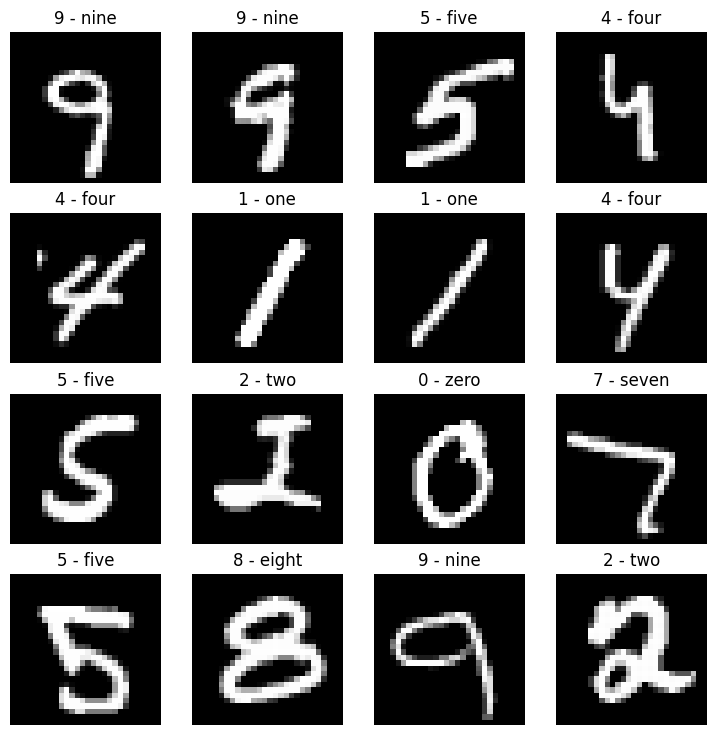

In [6]:
# Plotting some examples of the data in gray scale
torch.manual_seed(0)
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
    rand_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[rand_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)


### Preparing the DataLoader
* Convert the data into a python iterable, and batches

In [7]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              shuffle=False)

In [8]:
print(len(train_dataloader), len(test_dataloader))

1875 313


Image size: torch.Size([1, 28, 28])
Label: 1, label size torch.Size([])


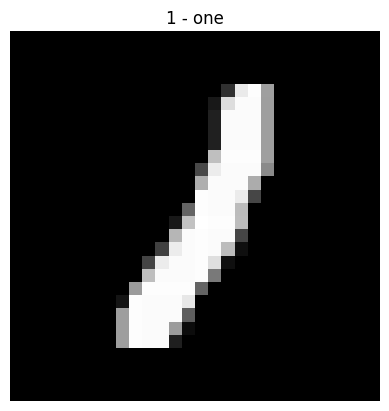

In [9]:
# Example 
train_features_batch, train_labels_batch = next(iter(train_dataloader))

rand_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[rand_idx], train_labels_batch[rand_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size {label.shape}")

### Setting up the model 

* Model attempt 1 was using only linear and ReLU layers, however for this model we will attempt another approach
* This model will use Convolutional layers

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

#### Custom training and test step functions for later use

In [11]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    """Performs a training with model traing to learn on data_loader"""
    train_loss , train_acc = 0, 0 

    model.train()

    for batch, (X, y) in enumerate(data_loader):

        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss 
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # from logits -> prediction labels
        

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()
            
    # average out train loss over all the train data
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)

    print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}")

In [12]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    """Performs a testing with model traing to learn on data_loader"""

    test_loss, test_acc = 0, 0

    model.eval()

    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)

            test_pred = model(X)

            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y, 
                                    y_pred=test_pred.argmax(dim=1))

        # Calculate the test loss
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.4f} | Test acc {test_acc:.2f}")

In [13]:
class MNISTModel(nn.Module):
    """
    This model uses the TinyVGG architecture
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            # Create a conv layer
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7, # Needed for shape of (1, 28, 28) using the cells below to find out
                      out_features=output_shape)
        )

    def forward(self, x):
        #print(x.shape)
        x = self.conv_block_1(x)
        #print(x.shape)
        x = self.conv_block_2(x)
        #print(x.shape)
        x = self.classifier(x)
        #print(x.shape)
        return x

In [14]:
torch.manual_seed(0)
model = MNISTModel(input_shape=1, # Color channel (image.shape (1))
                      hidden_units=10,
                      output_shape=len(class_names)).to(device)
model

MNISTModel(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

#### Calculating what number of in_features needed for our classifier layer

In [15]:
rand_image_tensor = torch.randn(size=(1, 28, 28))
rand_image_tensor.shape

torch.Size([1, 28, 28])

In [16]:
model(rand_image_tensor.unsqueeze(0).to(device))

tensor([[ 0.0948, -0.0733, -0.0005, -0.0458, -0.0342, -0.0300,  0.0194,  0.0091,
         -0.0301,  0.0071]], device='cuda:0', grad_fn=<AddmmBackward0>)

### Setting up a loss function and optimizer
* Accuracy
* Cross Entropy Loss - Multi-class Classification
* Stochastic gradient descent

In [17]:
def accuracy_fn(y_true, y_pred):
    """
    Calculates accuracy between truth labels and predictions.
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [18]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(),
                            lr=0.05)

In [19]:
def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
    """Prints difference between start and end time."""
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [20]:
torch.manual_seed(2)
torch.cuda.manual_seed(2)

from timeit import default_timer as timer
from tqdm.auto import tqdm

train_time_model_start_2 = timer()
epochs = 10

for epoch in tqdm(range(epochs)):
    print(f"Epoch {epoch}")
    train_step(model=model,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device)
    test_step(model=model,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               accuracy_fn=accuracy_fn,
               device=device)

train_time_model_end_2 = timer()

total_train_time_model_2 = print_train_time(start=train_time_model_start_2,
                                            end=train_time_model_end_2,
                                            device=device)


c:\Users\Nick\Documents\GitHub\CNNNumberClassifier\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0
Train loss: 0.41042 | Train acc: 86.00


  0%|          | 0/10 [00:14<?, ?it/s]


KeyboardInterrupt: 

In [21]:
import torch.utils
torch.manual_seed(0)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device=device):
    """Returs a dict conatining the results of model prediciton on data_loader"""
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            #Make our data device agnostic
            X, y = X.to(device), y.to(device)
            # Make predicitoins
            y_pred = model(X)

            # Accululate the loss and acc values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y,
                               y_pred=y_pred.argmax(dim=1))
            
        
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name" : model.__class__.__name__, # only works when model was created with a class,
            "model_loss" : loss.item(),
            "model_acc" : acc}

In [22]:
model_results = eval_model(model=model,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn,
                             device=device)
model_results

{'model_name': 'MNISTModel',
 'model_loss': 0.09642080217599869,
 'model_acc': 96.79512779552715}

In [23]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # prepare sample, add batch dimention and pass to target device
            sample = torch.unsqueeze(sample, dim=0).to(device)

            # forward pass
            pred_logit = model(sample)

            # get pred prob (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            pred_probs.append(pred_prob.cpu())

    return torch.stack(pred_probs)

In [24]:
import random
random.seed(42)
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

test_samples[0].shape

torch.Size([1, 28, 28])

Text(0.5, 1.0, '2 - two')

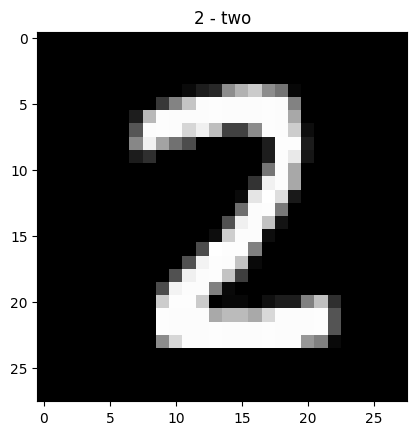

In [25]:
plt.imshow(test_samples[0].squeeze(), cmap="gray")
plt.title(class_names[test_labels[0]])

In [26]:
pred_probs = make_predictions(model=model,
                              data=test_samples)


In [27]:
pred_classses = pred_probs.argmax(dim=1)
pred_classses

tensor([2, 1, 2, 4, 6, 6, 4, 9, 1])

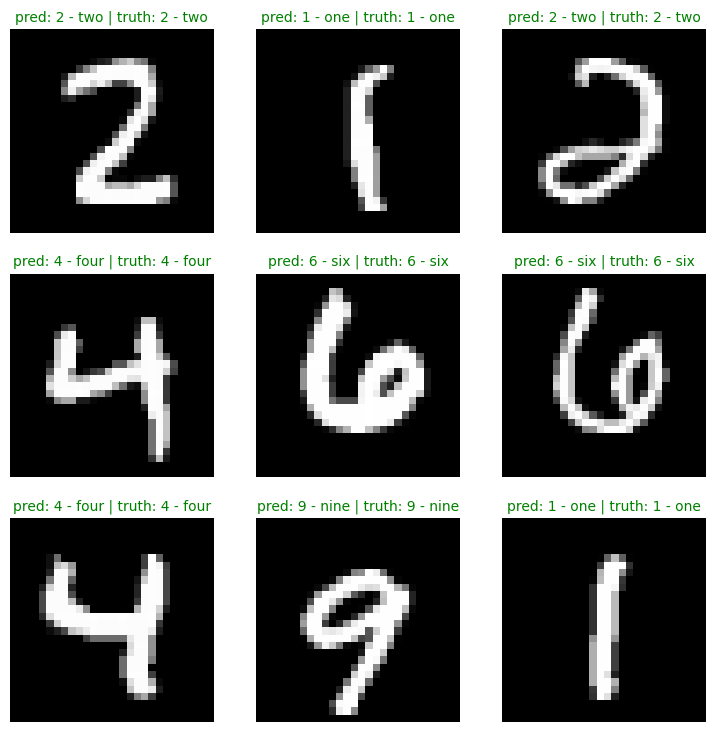

In [28]:
# Plot prediciotns
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
    plt.subplot(nrows, ncols, i+1)

    plt.imshow(sample.squeeze(), cmap="gray")

    #predition label in text form
    pred_label = class_names[pred_classses[i]]

    # get the truth label
    truth_label = class_names[test_labels[i]]

    title_text = f"pred: {pred_label} | truth: {truth_label}"

    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g")
    else:
        plt.title(title_text, fontsize=10, c="r")

    plt.axis(False)

### Saving the model

In [29]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "MNIST_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(),
           f=MODEL_SAVE_PATH)


Saving model to: models\MNIST_model.pth


### Loading it back

In [30]:
#Since we didnt save whole model, we will make a new state of a model class
loaded_model = MNISTModel(input_shape=1, # Color channel (image.shape (1))
                      hidden_units=10,
                      output_shape=len(class_names)).to(device)

#update the values in the model
loaded_model.load_state_dict(torch.load(MODEL_SAVE_PATH))

C:\Users\Nick\AppData\Local\Temp\ipykernel_19732\918619886.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(MODEL_SAVE_PATH))


<All keys matched successfully>